## Time Series Forecasting on Energy Consumption Data Using XGBoost

## Introduction

In this project, I will perform time series forecasting on energy consumption data using XGBoost model. This project is inspired by  Rob Mulla's tutorial on Kaggle.

https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost

## Dataset

Source of the data: https://www.kaggle.com/robikscube/hourly-energy-consumption#PJME_hourly.csv

Using dataset from PJM East. PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. The dataset contains hourly estimated energy consumption in megawatts (MW) from 2002 to 2018 for the east region in the United States.

## Project Goal

To predict energy consumption data using XGBoost model.

## Data Exploration

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score

In [107]:
# Import csv file
pjme = pd.read_csv("PJME_hourly.csv", index_col=[0], parse_dates=[0])

In [15]:
pjme.shape

(145366, 1)

In [16]:
pjme.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


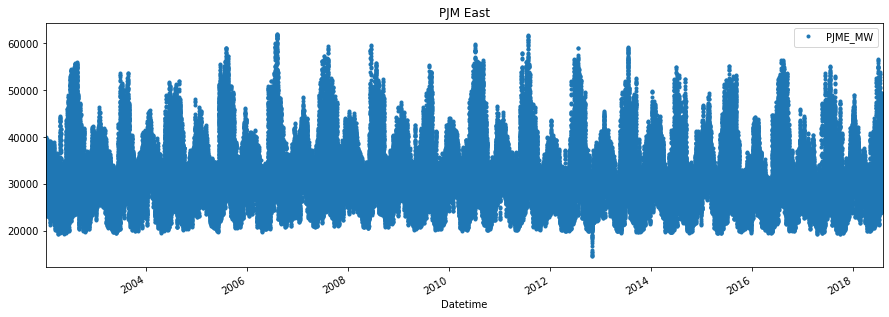

In [108]:
pjme.plot(style='.', figsize=(15,5), title='PJM East');

## Building Training/ Test Samples

Data after 2015 will be used as validation set

In [111]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [19]:
len(pjme_train)

113927

In [20]:
len(pjme_test)

31439

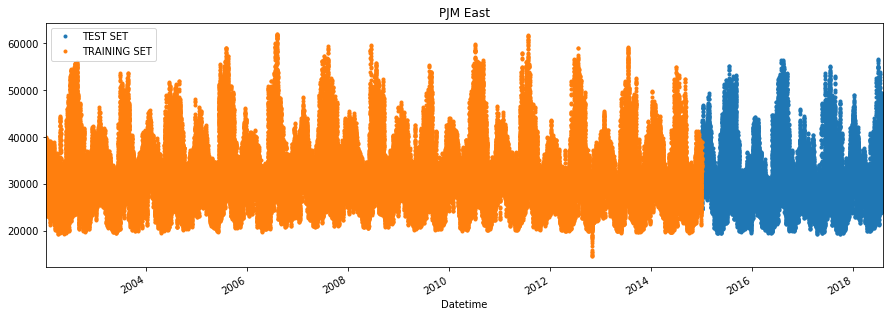

In [112]:
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.');


## Features Engineering

In [113]:
# Create features from datetime index
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour', 'dayofweek','month', 'quarter', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
    

In [114]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

##  Build XGBoost Model

In [115]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 50,
        verbose = False)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

## Feature Importances

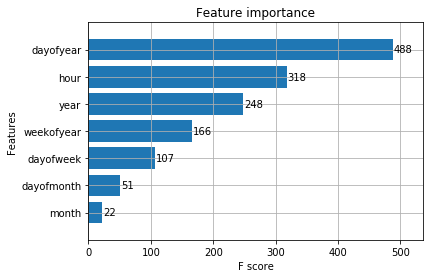

In [116]:
plot_importance(reg, height=0.8);

From the graph, we observe that the day of year was most commonly used,
follow by hour and year. Month has the least importance. 

## Forecast on Test Set

In [117]:
pjme_test['MW_Prediction'] = reg.predict(X_test)

In [118]:
pjme_test.head(5)

,PJME_MW,date,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,MW_Prediction
Datetime,,,,,,,,,,,
2015-12-31 01:00:00,24305.0,2015-12-31 01:00:00,1,3,12,4,2015,365,31,53,28804.365234
2015-12-31 02:00:00,23156.0,2015-12-31 02:00:00,2,3,12,4,2015,365,31,53,27663.097656
2015-12-31 03:00:00,22514.0,2015-12-31 03:00:00,3,3,12,4,2015,365,31,53,27125.912109
2015-12-31 04:00:00,22330.0,2015-12-31 04:00:00,4,3,12,4,2015,365,31,53,27125.912109
2015-12-31 05:00:00,22773.0,2015-12-31 05:00:00,5,3,12,4,2015,365,31,53,27125.912109


In [119]:
pjme_all = pd.concat([pjme_test, pjme_train], sort = False)

In [120]:
pjme_all.shape

(145366, 11)

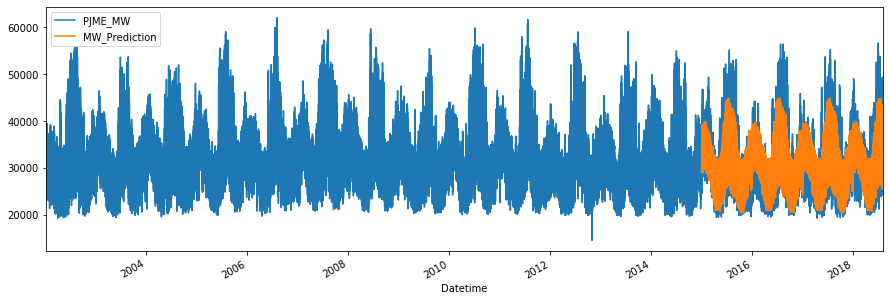

In [121]:
pjme_all[['PJME_MW', 'MW_Prediction']].plot(figsize=(15,5));

## Check first month of predictions

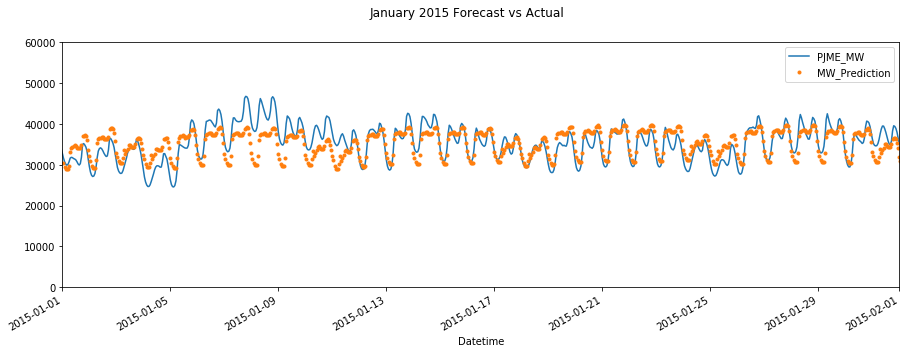

In [122]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = pjme_all[['PJME_MW', 'MW_Prediction']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)

plot = plt.suptitle('January 2015 Forecast vs Actual')

## Check first week of January predictions

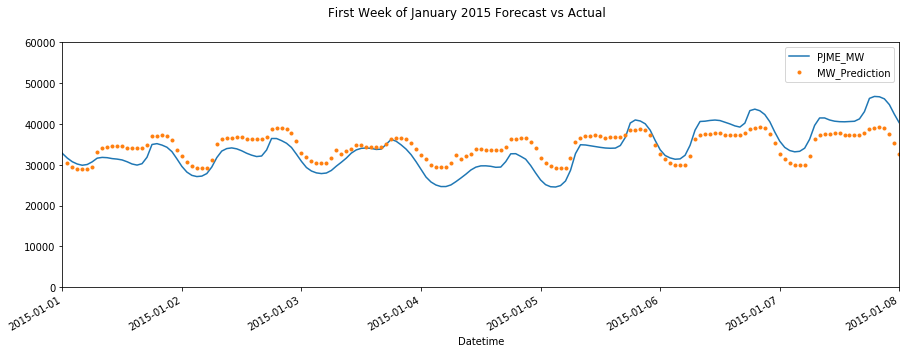

In [123]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = pjme_all[['PJME_MW', 'MW_Prediction']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)

plot = plt.suptitle('First Week of January 2015 Forecast vs Actual')

## Check first week of August predictions

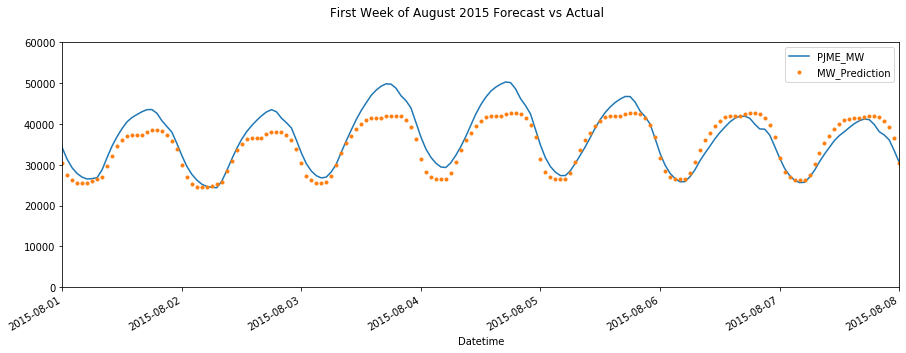

In [124]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = pjme_all[['PJME_MW', 'MW_Prediction']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='08-01-2015', upper='08-08-2015')
ax.set_ylim(0, 60000)

plot = plt.suptitle('First Week of August 2015 Forecast vs Actual')

## Evaluate the Performance

In [81]:
# The MAPE (Mean Absolute Percent Error) measures the size of the error
# in percentage terms.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [74]:
# Make predictions using the training and testing set
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [125]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

R^2   train: 0.79, test: 0.67
MSE   train: 8544896.67, test: 13780445.56
RMSE  train: 2923.17, test: 3712.20
MAE   train: 2144.22, test: 2848.89
MAPE  train: 6.49, test: 8.95


The Mean absolute percent accuracy (MAPA) is 91.05% (100 - 8.95)

## Check Best and Worst Predicted Day

In [126]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']

In [127]:
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)

In [128]:
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW', 'MW_Prediction', 'error', 'abs_error']]

In [129]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36986.964844 -8587.006429  8587.006429
2017 2     24          26445.083333   33814.503906 -7369.422445  7369.422445
2015 12    25          24466.083333   31584.923828 -7118.841390  7118.841390
2017 2     20          27070.583333   34100.781250 -7030.197754  7030.197754
2015 7     3           30024.875000   37021.031250 -6996.156169  6996.156169
2017 6     28          30531.208333   37526.589844 -6995.380371  6995.380371
     2     8           28523.833333   35511.699219 -6987.864258  6987.864258
     9     2           24201.458333   31180.390625 -6978.933105  6978.933105
     2     25          24344.458333   31284.279297 -6939.820150  6939.820150
2018 2     21          27572.500000   34477.417969 -6904.919352  6904.919352

From the data, we observe that:
- number 1 worst day, July 4th, 2016 is a holiday
- number 3 worst day, December 25th, 2015, is a holiday
- number 5 worst day, July 3rd, 2015, is a holiday eve.

Our model may benefit from adding a holiday indicator

In [130]:
# Best absolute predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 10    3           27705.583333   27775.351562  -69.768148  229.585205
2015 10    28          28500.958333   28160.875000  340.083740  388.023356
2016 10    8           25183.333333   25535.669922 -352.337402  401.017090
     5     1           24503.625000   24795.419922 -291.794515  428.289307
2017 10    29          24605.666667   24776.271484 -170.605225  474.628988
2016 9     16          29258.500000   29397.271484 -138.770833  491.070312
     3     20          27989.416667   27620.132812  369.284831  499.750488
     10    2           24659.083333   25134.919922 -475.836670  516.188232
2017 10    14          24949.583333   25399.728516 -450.145996  520.855794
2015 5     6           28948.666667   28710.271484  238.396077  546.640544

60 percent of the top 10 Best predicted days seem to be October.

In [131]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31753.224609  13432.608887  13432.608887
           14          44427.333333   31058.818359  13368.514404  13368.514404
     9     10          40996.166667   29786.179688  11209.987793  11209.987793
           9           43836.958333   32831.035156  11005.923828  11005.923828
2015 2     20          44694.041667   33814.503906  10879.535889  10879.535889
2018 1     6           43565.750000   33435.265625  10130.485921  10130.485921
2016 8     12          45724.708333   35609.312500  10115.394287  10115.394287
2017 5     19          38032.583333   28108.976562   9923.606689   9923.606689
     12    31          39016.000000   29314.683594   9701.315430   9701.315430
2015 2     21          40918.666667   31284.279297   9634.388184   9634.388184

## Plot best and worst predicted days

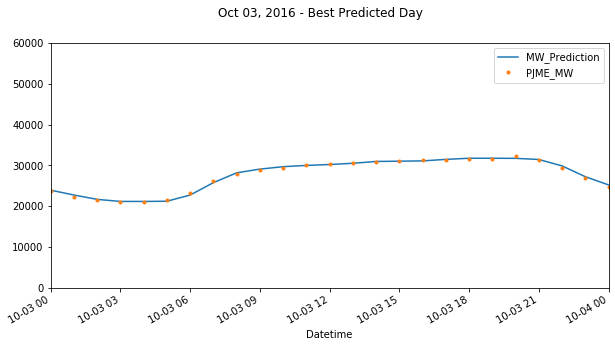

In [132]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)

_ = pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper = '10-04-2016')
plot = plt.suptitle('Oct 03, 2016 - Best Predicted Day')

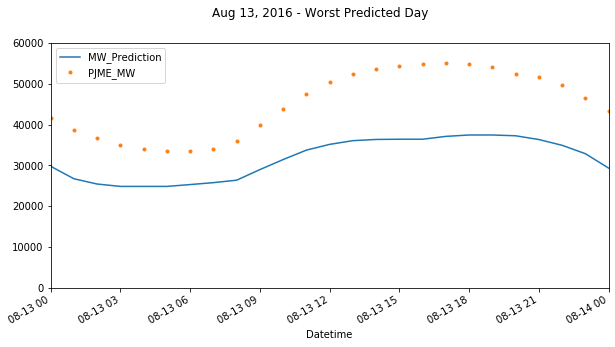

In [133]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)

_ = pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper = '08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

## Conclusion

Our XGBoost model has the Mean absolute percent accuracy (MAPA) of 91 percent.